In [ ]:
# Install necessary libraries
!pip install nltk spacy scikit-learn
!python -m spacy download en_core_web_sm

import nltk
from nltk.corpus import stopwords
import spacy
import string
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
import re
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline


# Download the stopwords from NLTK
nltk.download('stopwords')
nltk.download('punkt')

# Load the spaCy model for NER and POS tagging
nlp = spacy.load('en_core_web_sm')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 27.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Upload datasets
from google.colab import files

# Prompt to upload the unzipped file
uploaded = files.upload()

# Load the training data
train_data = pd.read_csv('propaganda_train.tsv', sep='\t', header=None, names=['label', 'sentence'])

# Load the testing data
test_data = pd.read_csv('propaganda_val.tsv', sep='\t', header=None, names=['label', 'sentence'])

Saving propaganda_train.tsv to propaganda_train.tsv
Saving propaganda_val.tsv to propaganda_val.tsv


In [ ]:
# Remove the first row of both training and testing data
train_data = train_data.drop(0).reset_index(drop=True)
test_data = test_data.drop(0).reset_index(drop=True)

In [ ]:
# Display the first few rows of the training data
print("Training Data:")
print(train_data.head(10))

Training Data:
             label                                           sentence
0   not_propaganda         No, <BOS> he <EOS> will not be confirmed. 
1   not_propaganda  This declassification effort <BOS> won’t make ...
2      flag_waving  The Obama administration misled the <BOS> Amer...
3   not_propaganda  “It looks like we’re capturing the demise of t...
4   not_propaganda           <BOS> Location: Westerville, Ohio <EOS> 
5  loaded_language  Hitler <BOS> annihilated <EOS> 400,000 Germans...
6   not_propaganda  A federal judge on Monday ordered U.S. immigra...
7   not_propaganda  <BOS> Kirstjen Nielsen (@SecNielsen) <EOS> Nov...
8            doubt  As noted above, at this point literally every ...
9   not_propaganda  Britain doesn't need more hate even just for a...


In [ ]:
# Display the first few rows of the testing data
print("\nTesting Data:")
print(test_data.head(10))


Testing Data:
                       label  \
0             not_propaganda   
1  causal_oversimplification   
2   appeal_to_fear_prejudice   
3             not_propaganda   
4                 repetition   
5      name_calling,labeling   
6            loaded_language   
7             not_propaganda   
8                flag_waving   
9                      doubt   

                                            sentence  
0  On average, between 300 and 600 infections are...  
1  Mostly because <BOS> the country would not las...  
2  Lyndon Johnson <BOS> gets Earl Warren and Sen....  
3           <BOS> You <EOS> may opt out at anytime.   
4  It must be exacted from him directly in order ...  
5  Is it any wonder that priests and laity alike ...  
6  Health workers have been asked to work with co...  
7       The Best of <BOS> Jacob <EOS> G. Hornberger   
8  Trump began his remarks by setting out <BOS> I...  
9  <BOS> Now, the pope’s reply to my testimony wa...  


In [ ]:
# Convert labels to binary: 'propaganda' or 'not_propaganda'
train_data['binary_label'] = train_data['label'].apply(lambda x: 'not_propaganda' if x == 'not_propaganda' else 'propaganda')
test_data['binary_label'] = test_data['label'].apply(lambda x: 'not_propaganda' if x == 'not_propaganda' else 'propaganda')

In [ ]:
# Custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.punctuation = set(string.punctuation)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self._preprocess)

    def _preprocess(self, text):
        # Lowercasing
        text = text.lower()

        # Remove <BOS> and <EOS> tokens
        text = re.sub('<BOS>|<EOS>', '', text)

        # Apply spaCy pipeline
        doc = nlp(text)

        # Remove stopwords and punctuation, and retain only relevant words (nouns, verbs, adjectives, etc.)
        words = [
            f"{token.text}_{token.pos_}" for token in doc
            if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV'}
            and token.text.lower() not in self.stop_words
            and token.text not in self.punctuation
        ]

        # Include named entities in the text
        entities = [f"{ent.text}_ENTITY" for ent in doc.ents]

        # Combine words and entities
        processed_text = words + entities

        # Return preprocessed text
        return ' '.join(processed_text)

In [ ]:
# Initialize the text preprocessor
text_preprocessor = TextPreprocessor()

# Apply text preprocessing to the training and testing data
train_data['cleaned_sentence'] = text_preprocessor.transform(train_data['sentence'])
test_data['cleaned_sentence'] = text_preprocessor.transform(test_data['sentence'])

In [ ]:
# Verify the new columns
print("\nTraining Data with Cleaned Sentences:")
print(train_data.head(10))
print(train_data.columns)

print("\nTesting Data with Cleaned Sentences:")
print(test_data.head(10))
print(test_data.columns)


Training Data with Cleaned Sentences:
             label                                           sentence  \
0   not_propaganda         No, <BOS> he <EOS> will not be confirmed.    
1   not_propaganda  This declassification effort <BOS> won’t make ...   
2      flag_waving  The Obama administration misled the <BOS> Amer...   
3   not_propaganda  “It looks like we’re capturing the demise of t...   
4   not_propaganda           <BOS> Location: Westerville, Ohio <EOS>    
5  loaded_language  Hitler <BOS> annihilated <EOS> 400,000 Germans...   
6   not_propaganda  A federal judge on Monday ordered U.S. immigra...   
7   not_propaganda  <BOS> Kirstjen Nielsen (@SecNielsen) <EOS> Nov...   
8            doubt  As noted above, at this point literally every ...   
9   not_propaganda  Britain doesn't need more hate even just for a...   

     binary_label                                   cleaned_sentence  
0  not_propaganda                                     confirmed_VERB  
1  not_propagan

In [ ]:
# Define the hyperparameter grid for both CountVectorizer and TfidfVectorizer
param_grid = {
    'vectorizer__max_features': [1000, 5000, 10000],
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'classifier__alpha': [0.1, 0.5, 1.0]
}

In [ ]:
# Define a function to create a pipeline and perform hyperparameter tuning and evaluation
def evaluate_model(vectorizer):
    # Create a pipeline with SMOTE and Naive Bayes
    pipeline = ImbPipeline(steps=[
        ('preprocessor', text_preprocessor),
        ('vectorizer', vectorizer),
        ('smote', SMOTE(random_state=42)),
        ('classifier', MultinomialNB())
    ])

    # Create RandomizedSearchCV object
    random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, scoring='accuracy', cv=5, random_state=42)

    # Split the training data into training and testing sets
    X_train, X_val, y_train, y_val = train_test_split(train_data['cleaned_sentence'], train_data['binary_label'], test_size=0.2, random_state=42)

    # Fit RandomizedSearchCV to the training data
    random_search.fit(X_train, y_train)

    # Print the best hyperparameters found
    print(f"Best Hyperparameters for {vectorizer.__class__.__name__}:", random_search.best_params_)

    # Apply cross-validation to the entire training set using the best pipeline
    cv_scores = cross_val_score(random_search.best_estimator_, train_data['cleaned_sentence'], train_data['binary_label'], cv=5, scoring='accuracy')

    # Print the cross-validation scores
    print(f"Cross-Validation Scores for {vectorizer.__class__.__name__}:", cv_scores)
    print(f"Mean CV Accuracy for {vectorizer.__class__.__name__}:", cv_scores.mean())

    # Predict the labels on the validation set using the best estimator from RandomizedSearchCV
    val_predictions = random_search.best_estimator_.predict(X_val)

    # Print out the classification report for the validation set
    print(f"Validation Set Classification Report for {vectorizer.__class__.__name__}:")
    print(classification_report(y_val, val_predictions))

    # Compute and plot the confusion matrix for the validation set
    cm = confusion_matrix(y_val, val_predictions, labels=['propaganda', 'not_propaganda'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['propaganda', 'not_propaganda'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {vectorizer.__class__.__name__}")
    plt.show()

    return random_search.best_estimator_

Best Hyperparameters for TfidfVectorizer: {'vectorizer__ngram_range': (1, 1), 'vectorizer__max_features': 10000, 'classifier__alpha': 1.0}
Cross-Validation Scores for TfidfVectorizer: [0.61904762 0.6252588  0.5942029  0.64182195 0.63278008]
Mean CV Accuracy for TfidfVectorizer: 0.622622269185502
Validation Set Classification Report for TfidfVectorizer:
                precision    recall  f1-score   support

not_propaganda       0.62      0.61      0.61       241
    propaganda       0.62      0.63      0.62       242

      accuracy                           0.62       483
     macro avg       0.62      0.62      0.62       483
  weighted avg       0.62      0.62      0.62       483



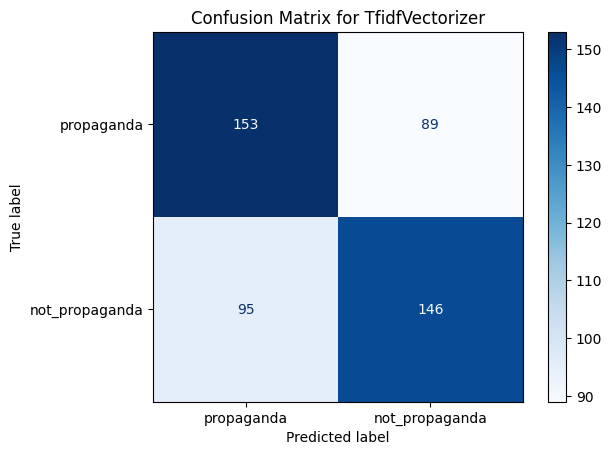

In [ ]:
# Evaluate using TfidfVectorizer (TF-IDF)
best_tfidf_model = evaluate_model(TfidfVectorizer())

In [ ]:
# Use the best model (either best_bow_model or best_tfidf_model) to predict on the test set
test_predictions = best_tfidf_model.predict(test_data['cleaned_sentence'])

In [ ]:
# Print out the classification report for the test set
print("Test Set Classification Report:")
print(classification_report(test_data['binary_label'], test_predictions))

Test Set Classification Report:
                precision    recall  f1-score   support

not_propaganda       0.68      0.63      0.65       301
    propaganda       0.63      0.67      0.65       279

      accuracy                           0.65       580
     macro avg       0.65      0.65      0.65       580
  weighted avg       0.65      0.65      0.65       580



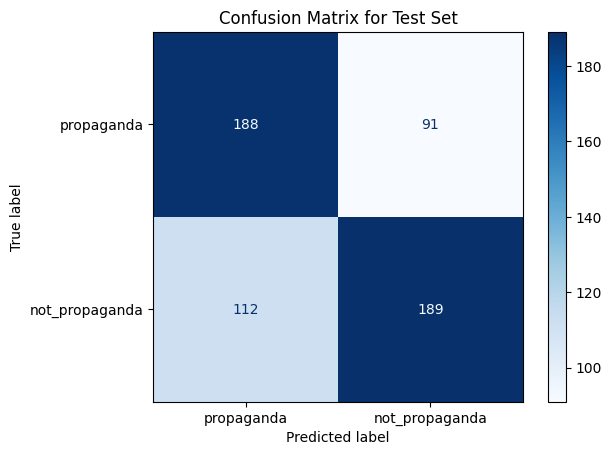

In [ ]:
# Compute and plot the confusion matrix for the test set
cm = confusion_matrix(test_data['binary_label'], test_predictions, labels=['propaganda', 'not_propaganda'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['propaganda', 'not_propaganda'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Test Set")
plt.show()